In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: giải nén file zip

import zipfile
import os

# Path to the zip file
zip_file_path = "/content/drive/MyDrive/data_final.zip"

# Path to extract the files to
extract_to_path = "/content/drive/MyDrive/"

# Create the target directory if it doesn't exist
os.makedirs(extract_to_path, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all files to the target directory
    zip_ref.extractall(extract_to_path)

print("Zip file extracted successfully to:", extract_to_path)


Zip file extracted successfully to: /content/drive/MyDrive/


In [ ]:
!pip install keras-nightly

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]


import numpy as np
import keras
from keras import layers
# from keras import ops
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os
import scipy.io
import shutil

In [ ]:
from keras.utils import image_dataset_from_directory
from keras.applications.resnet import preprocess_input, decode_predictions
from pathlib import Path

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelBinarizer

from keras import layers
from keras.layers import LSTM, Dense, Dropout, Conv2D, Conv3D, MaxPooling2D, Activation, Dropout, Flatten, Input, MultiHeadAttention, Embedding, BatchNormalization, Add, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.utils import to_categorical, plot_model
from keras.models import load_model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import imutils



# **Đọc ảnh cho model ResNet50 Feature Extractor và ResNet50 Finetuning FPN**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/data_final"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "train"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [ ]:
def get_data(height, width):
    images = []
    labels = []
    bboxes = []
    count = 0
    # Lấy danh sách các file trong thư mục ANNOTATIONS_PATH
    csvFileNames = os.listdir(ANNOTS_PATH)
    # Duyệt qua các file CSV để đọc dữ liệu
    for csvFileName in csvFileNames:

        # Mở file CSV
        csvPath = os.path.join(ANNOTS_PATH, csvFileName)
        with open(csvPath, 'r') as f:
            rows = f.read().strip().split("\n")
            print(rows)
        # Đọc từng dòng
        for row in rows:
            # Lấy thông tin file ảnh
            (filename, class_name ,h, w, x1, y1, x2, y2, classes) = row.split(",")

            # Đọc file ảnh với hàm opencv
            imagePath = os.path.join(IMAGES_PATH, filename)
            if os.path.exists(imagePath):
                # print("Reading image:", imagePath)
                image = cv2.imread(imagePath)
                if image is not None:
                    count += 1
                    print(count)
                    # print("Image shape:", image.shape)
                    (h, w, depth) = image.shape

                    # Chuẩn hóa về miền giá trị [0..1]
                    x1 = float(x1) / w
                    y1 = float(y1) / h
                    x2 = float(x2) / w
                    y2 = float(y2) / h
                    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = load_img(imagePath, target_size=(height, width),
                                    #  color_mode='rgb',
                                    #  grayscale=True
                                     )
                    image = img_to_array(image)


                    # Load lại ảnh với hàm load_img với kích thước height, width
                    # image = cv2.resize(image, (width, height))
                    # image = image.astype('float32') / 255.0    # Sử dụng cv2.resize để thay đổi kích thước

                    images.append(image)
                    labels.append(classes)
                    bboxes.append((x1, y1, x2, y2))
            else:
                print("Image not found:", imagePath)

    return images, labels, bboxes

# Sử dụng hàm get_data với các đường dẫn được cung cấp
images, labels, bboxes = get_data(128, 128)
print("Data:", len(images))


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803

In [ ]:
def preprocess_input(images, labels, bboxes):
 # Chuyển các dữ liệu về numpy số thực
 # Chuyển ảnh về miền giá trị [0..1]
 images = np.array(images, dtype='float32')/255.0
 labels = np.array(labels)
 bboxes = np.array(bboxes)

 # one-hot encoding các labels
 lb = LabelBinarizer()
 labels = lb.fit_transform(labels)

 # Chia thành 2 tập: train và valid
 images_train, images_valid = train_test_split(images, test_size=0.1)
 labels_train, labels_valid = train_test_split(labels, test_size=0.1)
 bboxes_train, bboxes_valid = train_test_split(bboxes, test_size=0.1)

 return (images_train,labels_train,bboxes_train), (images_valid,labels_valid,bboxes_valid)
if __name__ == "__main__":
#  images, labels, bboxes = get_data(224, 224)
#  print("Data: ", len(images))

 (images_train,labels_train,bboxes_train), (images_valid,labels_valid,bboxes_valid) = preprocess_input(images, labels, bboxes)
 print("Train: ", len(images_train))
 print("Valid: ", len(images_valid))


Train:  5009
Valid:  557


# **Đọc ảnh cho model MLP, CNN, ResNet**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/data_final2"
TRAIN_PATH = 'train'
# VALID_PATH = 'Dataset'
TEST_PATH = '/content/drive/MyDrive/test_data'

CLASSES = ['5', '6', '7', '8', '9']
seed_train_validation = 1
train_ds, val_ds = image_dataset_from_directory(Path.cwd() / BASE_PATH,
                                             subset="both",
                                             image_size=(128, 128),
                                             batch_size=32,
                                             validation_split=0.1,
                                            #  color_mode = 'grayscale',
                                             seed = seed_train_validation,
                                             label_mode='categorical',
                                                shuffle = True)


test_ds = image_dataset_from_directory(Path.cwd() / TEST_PATH,
                                            # subset = 'test',
                                            image_size=(128, 128),
                                            batch_size=32,
                                            # seed = seed_train_validation,
                                            label_mode='categorical')


Found 2621 files belonging to 5 classes.
Using 2359 files for training.
Using 262 files for validation.
Found 592 files belonging to 5 classes.


Chuẩn hóa

In [ ]:
import tensorflow as tf
normalization_layer = tf.keras.layers.Rescaling(1./255)


In [ ]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds))

first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.32156864 0.91372555


# **MLP**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 Dense_1 (Dense)             (None, 1024)              50332672  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 Dense_2 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 5)                 5125      
                                                                 
Total params: 51387397 (196.03 MB)
Trainable params: 5

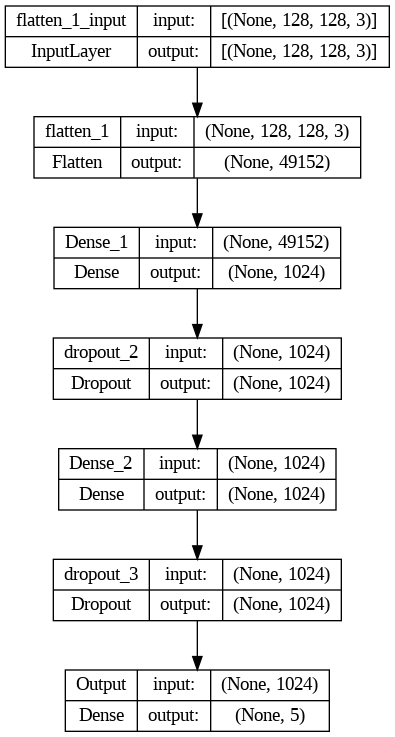

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(128,128,3)))
model.add(Dense(name='Dense_1', units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(name='Dense_2', units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(name='Output', units=5, activation='softmax'))
model.summary()
plot_model(model, to_file="mlp.png", show_shapes=True)


In [ ]:
#
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/mlp.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_accuracy')
callbacks = [checkpointer]

sgd = SGD(learning_rate=0.001, momentum=0.09)
model.compile(optimizer=sgd, metrics=['accuracy'], loss="categorical_crossentropy")
h = model.fit(train_ds, epochs=40, batch_size=16, verbose=1, shuffle=True,
            validation_data=val_ds,
            callbacks=callbacks
          )
model.save("/content/drive/MyDrive/mlp.h5")


Epoch 1/40
157/157 [==============================] - ETA: 0s - loss: 1.5792 - accuracy: 0.2576
Epoch 1: val_accuracy improved from -inf to 0.28905, saving model to /content/drive/MyDrive/mlp.h5
157/157 [==============================] - 23s 134ms/step - loss: 1.5792 - accuracy: 0.2576 - val_loss: 1.5335 - val_accuracy: 0.2890
Epoch 2/40
155/157 [============================>.] - ETA: 0s - loss: 1.5574 - accuracy: 0.2740
Epoch 2: val_accuracy improved from 0.28905 to 0.36984, saving model to /content/drive/MyDrive/mlp.h5
157/157 [==============================] - 22s 135ms/step - loss: 1.5564 - accuracy: 0.2743 - val_loss: 1.5117 - val_accuracy: 0.3698
Epoch 3/40
157/157 [==============================] - ETA: 0s - loss: 1.5391 - accuracy: 0.2781
Epoch 3: val_accuracy did not improve from 0.36984
157/157 [==============================] - 21s 127ms/step - loss: 1.5391 - accuracy: 0.2781 - val_loss: 1.4975 - val_accuracy: 0.3537
Epoch 4/40
157/157 [==============================] - ETA:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


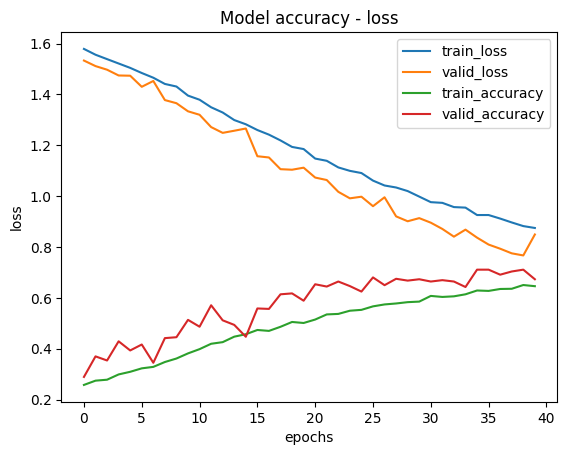

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title("Model accuracy - loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy'], loc='upper right')
plt.show()

In [ ]:
file_model = '/content/drive/MyDrive/model/mlp.h5'
loaded_model = load_model(file_model)

results = loaded_model.evaluate(test_ds, batch_size=16)
print("test loss, test acc:", results)

19/19 [==============================] - 6s 198ms/step - loss: 270.5723 - accuracy: 0.0287
test loss, test acc: [270.5722961425781, 0.02871621586382389]


# **CNN**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 MaxPooling2D_1 (MaxPooling  (None, 64, 64, 128)       0         
 2D)                                                             
                                                                 
 Conv2D_2 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 MaxPooling2D_2 (MaxPooling  (None, 32, 32, 256)       0         
 2D)                                                             
                                                                 
 Conv2D_3 (Conv2D)           (None, 32, 32, 512)       1180160   
                                                                 
 flatten (Flatten)           (None, 524288)           

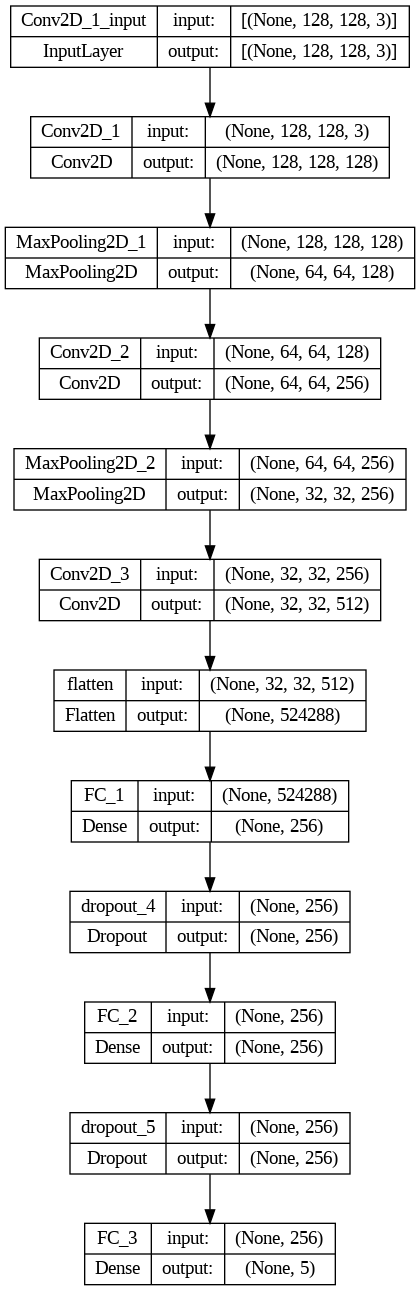

In [ ]:
model = Sequential()

model.add(Conv2D(128, (3,3), padding='same',
                 activation='relu',
                 input_shape=(128,128,3),
                 name='Conv2D_1'))
model.add(MaxPooling2D(name='MaxPooling2D_1'))
model.add(Conv2D(256, (3,3), padding='same', activation='relu', name='Conv2D_2'))
model.add(MaxPooling2D(name='MaxPooling2D_2'))
model.add(Conv2D(512, (3,3), padding='same', activation='relu', name='Conv2D_3'))


model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='FC_1'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', name='FC_2'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax', name='FC_3'))
model.summary()
plot_model(model, to_file="cnn.png", show_shapes=True)


In [ ]:
# cnn
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/cnn.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_accuracy')
callbacks = [checkpointer]

sgd = SGD(learning_rate=0.001, momentum=0.09)
model.compile(optimizer=sgd, metrics=['accuracy'], loss="categorical_crossentropy")
h = model.fit(train_ds, epochs=40, batch_size=16, verbose=1, shuffle=True,
            validation_data=val_ds,
            callbacks=callbacks
          )
model.save("/content/drive/MyDrive/cnn.h5")


Epoch 1/40
65/65 [==============================] - ETA: 0s - loss: 1.2501 - accuracy: 0.4532
Epoch 1: val_accuracy improved from -inf to 0.42105, saving model to /content/drive/MyDrive/cnn.h5
65/65 [==============================] - 26s 262ms/step - loss: 1.2501 - accuracy: 0.4532 - val_loss: 1.0163 - val_accuracy: 0.4211
Epoch 2/40
64/65 [============================>.] - ETA: 0s - loss: 1.0673 - accuracy: 0.4751
Epoch 2: val_accuracy improved from 0.42105 to 0.52632, saving model to /content/drive/MyDrive/cnn.h5
65/65 [==============================] - 20s 301ms/step - loss: 1.0675 - accuracy: 0.4756 - val_loss: 0.9631 - val_accuracy: 0.5263
Epoch 3/40
64/65 [============================>.] - ETA: 0s - loss: 1.0678 - accuracy: 0.4492
Epoch 3: val_accuracy did not improve from 0.52632
65/65 [==============================] - 10s 124ms/step - loss: 1.0679 - accuracy: 0.4493 - val_loss: 0.9599 - val_accuracy: 0.4386
Epoch 4/40
64/65 [============================>.] - ETA: 0s - loss: 1.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


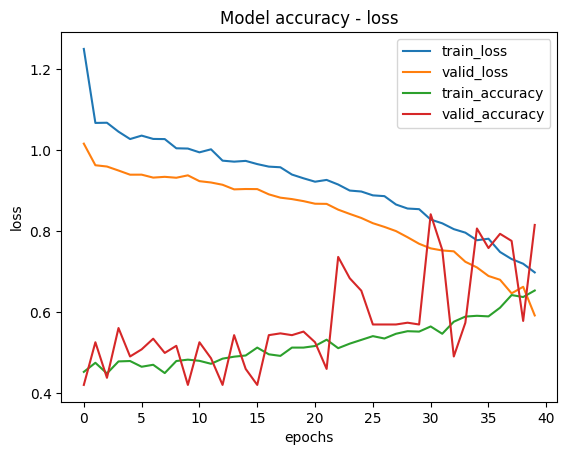

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title("Model accuracy - loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy'], loc='upper right')
plt.show()

In [ ]:
file_model = '/content/drive/MyDrive/model/cnn.h5'
loaded_model = load_model(file_model)

results = loaded_model.evaluate(test_ds, batch_size=16)
print("test loss, test acc:", results)

19/19 [==============================] - 64s 3s/step - loss: 262.9800 - accuracy: 0.2247
test loss, test acc: [262.98004150390625, 0.2246621549129486]


# **Resnet50**

In [ ]:
def identity_block(X, filters, f=3):
 F1, F2, F3 = filters

 shortcut = X

 # 1 Convolution 1x1
 X = Conv2D(filters=F1, kernel_size=1, padding='valid')(X)
 X = BatchNormalization(axis = 3)(X)
 X = Activation('relu')(X)
 # 2 Convolution 3x3
 X = Conv2D(filters=F2, kernel_size=f, padding='same')(X)
 X = BatchNormalization(axis = 3)(X)
 X = Activation('relu')(X)
 # 3 Convolution 1x1
 X = Conv2D(filters=F3, kernel_size=1, padding='valid')(X)
 X = BatchNormalization(axis = 3)(X)
#  X = Activation('relu')(X)
 # 4 shortcut
 X = Add()([shortcut,X])
 X = Activation('relu')(X)
 return X

In [ ]:
# input_shape = (32,32,16)
# input = Input(shape = input_shape)
# output = identity_block(input, filters=[16,16,16])
# model = Model(inputs=input, outputs=output)
# print(model.summary())

In [ ]:
def convolutional_block(input_tensor, filters, s, f=3): #f=3, s=2
 F1, F2, F3 = filters

 # Lưu giá trị Input (tạo shortcut)
#  shortcut = X
 # 1. Convolution 1x1
 X = Conv2D(filters=F1, kernel_size=1, strides=(s,s), padding='valid')(input_tensor)
 X = BatchNormalization(axis = 3)(X)
 X = Activation('relu')(X)
 # 2. Convolution 3x3
 X = Conv2D(filters=F2, kernel_size=f, padding='same', strides=(1,1))(X)
 X = BatchNormalization(axis = 3)(X)
 X = Activation('relu')(X)
 # 3. Convolution 1x1
 X = Conv2D(filters=F3, kernel_size=1, padding='valid', strides=(1,1))(X)
 X = BatchNormalization(axis = 3)(X)

 # 4. Convolutional shortcut
 shortcut = Conv2D(filters=F3, kernel_size=1, strides=(s,s), padding='valid')(input_tensor)
 shortcut = BatchNormalization(axis = 3)(shortcut)

 # 5. Shortcut

 X = Add()([X, shortcut])
 X = Activation('relu')(X)
 return X

In [ ]:
# input = Input(shape=(32,32,16))
# f = 3
# s = 2
# output = convolutional_block(input, filters=[16,16,16],f=f, s=s)
# model = Model(inputs=input, outputs=output)
# print(model.summary())


Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 16)]         0         []                            
                                                                                                  
 conv2d_301 (Conv2D)         (None, 16, 16, 16)           272       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_301 (B  (None, 16, 16, 16)           64        ['conv2d_301[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_270 (Activation  (None, 16, 16, 16)           0         ['batch_normalization_3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']          

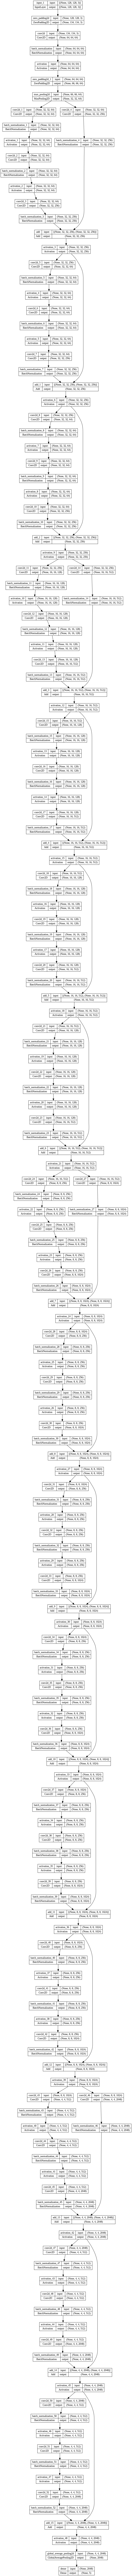

In [ ]:
import tensorflow as tf
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Add
from keras.models import Model

def ResNet50(input_shape=(128, 128, 3), classes=5):
 input = Input(input_shape)

 # Zero-Padding
 X = ZeroPadding2D((3, 3))(input)

 # Stage 1: 1 tầng
 X = Conv2D(64, (7, 7), strides=(2, 2))(X)
 X = BatchNormalization(axis=3)(X)
 X = Activation('relu')(X)
 X = ZeroPadding2D((1, 1))(X)
 X = MaxPooling2D((3, 3), strides=(2, 2))(X)


 # Stage 2: 3x3 = 9 tầng
 X = convolutional_block(X, filters=[64, 64, 256], s=1)
 X = identity_block(X, filters=[64, 64, 256])
 X = identity_block(X, filters=[64, 64, 256])
 # Stage 3: 3x4 = 12 tầng
 X = convolutional_block(X, filters=[128,128,512], s=2)
 X = identity_block(X, filters=[128,128,512])
 X = identity_block(X, filters=[128,128,512])
 X = identity_block(X, filters=[128,128,512])

 # Stage 4: 3x6 = 18 tầng
 X = convolutional_block(X, filters=[256,256,1024], s=2)
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 X = identity_block(X, filters=[256, 256, 1024])
 # Stage 5: 3x3 = 9 tầng
 X = convolutional_block(X, filters=[512,512,2048], s=2)
 X = identity_block(X, filters=[512,512,2048])
 X = identity_block(X, filters=[512,512,2048])

 X = GlobalAveragePooling2D()(X)
 # output layer
#  X = Flatten()(X)
 X = Dense(classes, activation='softmax')(X)


 # Tạo model
 model = Model(inputs=input, outputs=X)
 return model
model = ResNet50()
print(model.summary())
plot_model(model, to_file="mlp.png", show_shapes=True)




In [ ]:
sgd = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=sgd, metrics=['accuracy'], loss="categorical_crossentropy")

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/resnet50.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_accuracy')
callbacks = [checkpointer]
h = model.fit(train_ds, epochs=40, batch_size=16, verbose=1, shuffle=True,
            validation_data=val_ds,
            callbacks=callbacks
          )
model.save("/content/drive/MyDrive/resnet50.h5")

Epoch 1/40
65/65 [==============================] - ETA: 0s - loss: 1.1572 - accuracy: 0.5322
Epoch 1: val_accuracy improved from -inf to 0.48246, saving model to /content/drive/MyDrive/resnet50.h5
65/65 [==============================] - 343s 5s/step - loss: 1.1572 - accuracy: 0.5322 - val_loss: 1.0790 - val_accuracy: 0.4825
Epoch 2/40
65/65 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7895
Epoch 2: val_accuracy did not improve from 0.48246
65/65 [==============================] - 11s 156ms/step - loss: 0.5568 - accuracy: 0.7895 - val_loss: 1.2015 - val_accuracy: 0.4211
Epoch 3/40
65/65 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.8314
Epoch 3: val_accuracy did not improve from 0.48246
65/65 [==============================] - 11s 153ms/step - loss: 0.4218 - accuracy: 0.8314 - val_loss: 1.0872 - val_accuracy: 0.4649
Epoch 4/40
64/65 [============================>.] - ETA: 0s - loss: 0.2474 - accuracy: 0.8945
Epoch 4: val_accuracy im

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


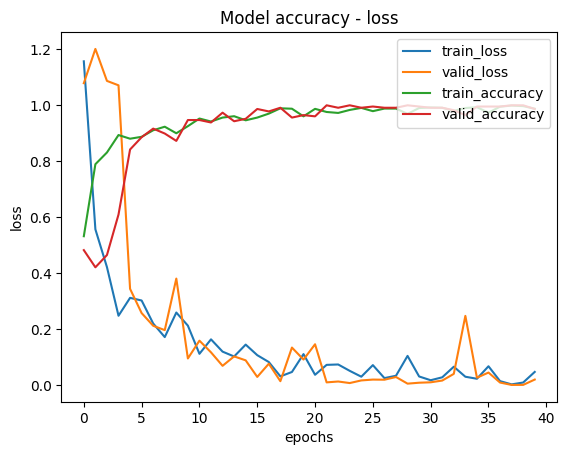

In [ ]:
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title("Model accuracy - loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy'], loc='upper right')
plt.show()

In [ ]:
file_model = '/content/drive/MyDrive/model/resnet50.h5'
loaded_model = load_model(file_model)

results = loaded_model.evaluate(test_ds, batch_size=16)
print("test loss, test acc:", results)

19/19 [==============================] - 38s 2s/step - loss: 8141.2490 - accuracy: 0.1909
test loss, test acc: [8141.2490234375, 0.19087837636470795]


Shape test (1, 128, 128, 3)
1/1 [==============================] - 3s 3s/step
[[1. 0. 0. 0. 0.]]
itemindex:(array([0]), array([0]))
probability: 100.0%
Predicted class :  5


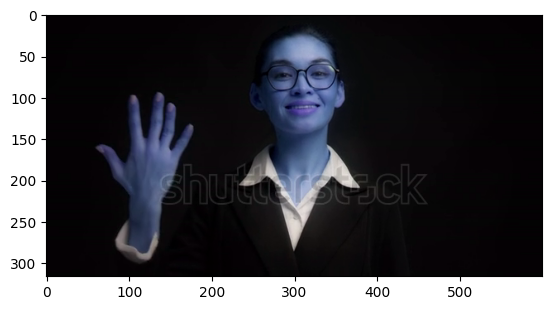

In [ ]:
def test_predict(test_img):
    labels = ["5", "6", "7", "8", "9"]
    img = cv2.imread(test_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (128, 128))
    img_arr = np.asarray(img_resize)
    img_arr = np.expand_dims(img_arr, axis=0)

    print('Shape test', img_arr.shape)
    pred = loaded_model.predict(img_arr)
    print(pred)
    itemindex = np.where(pred == np.max(pred))
    print('itemindex:{}'.format(itemindex))
    prediction = itemindex[1][0]
    print("probability: " + str(np.max(pred) * 100) + "%\nPredicted class : ", labels[prediction])

    img = cv2.imread(test_img)
    plt.imshow(img)
file_model = '/content/drive/MyDrive/model/resnet50.h5'

loaded_model = load_model(file_model)
test_predict('/content/drive/MyDrive/test_data/hand5/img0046.png')


# **Resnet50 Feature Extractor box**

In [ ]:
from keras.applications import ResNet50
from tensorflow import keras
from keras import layers, Model

def ResNet50_Transfer_box():

    inputs = keras.Input(shape=(128, 128, 3))

    data_augmentation = keras.Sequential([
        # layers.Resizing(256, 256),
        layers.GaussianNoise(0.2),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_tensor=data_augmentation)

    # Đóng băng các lớp trong base_model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(filters=128, kernel_size=1, padding='valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=1, padding='valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=1, padding='valid')(x)


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    label = layers.Dense(5, activation="softmax", name="class_label")(x)

    bbox = layers.Dense(4, activation="sigmoid", name="bounding_box")(x)

    model = Model(inputs=inputs, outputs=[label, bbox])
    losses = {
        "class_label": "categorical_crossentropy",
        "bounding_box": "mean_squared_error",
    }

    # Định nghĩa losses cho các hàm lossWeights
    lossWeights = {
        "class_label": 1.0,
        "bounding_box": 1.0
    }

    # Khởi tạo optimizer
    opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.09)
    model.compile(loss=losses, optimizer=opt,
                  metrics={"class_label": "accuracy",
                           "bounding_box": "accuracy"},
                  loss_weights=lossWeights)

    return model


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                             

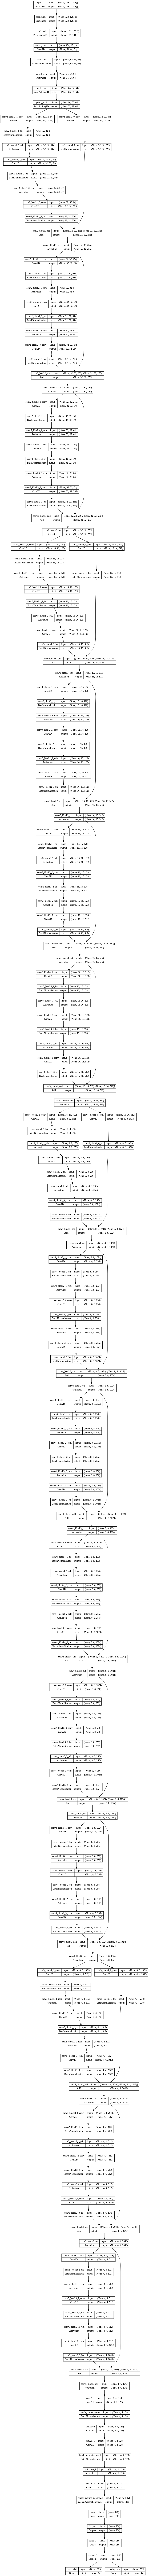

In [ ]:
model = ResNet50_Transfer_box()
print(model.summary())
plot_model(model, to_file="resnet50featureextractor.png", show_shapes=True)


In [ ]:
# resnet152
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/resnet50_transfer_box.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_bounding_box_accuracy')
callbacks = [checkpointer]

# sgd = SGD(learning_rate=0.001)
# model.compile(optimizer=sgd, metrics=['accuracy'], loss="categorical_crossentropy")
h = model.fit(x = images_train, y = [labels_train, bboxes_train], epochs=40, batch_size=16, verbose=1,
            validation_data=(images_valid, [labels_valid, bboxes_valid]),
            callbacks=callbacks,
              shuffle=True
          )
model.save("/content/drive/MyDrive/resnet50_transfer_box.h5")


Epoch 1/40
314/314 [==============================] - ETA: 0s - loss: 1.7318 - class_label_loss: 1.6571 - bounding_box_loss: 0.0747 - class_label_accuracy: 0.2094 - bounding_box_accuracy: 0.3643
Epoch 1: val_bounding_box_accuracy improved from -inf to 0.31598, saving model to /content/drive/MyDrive/resnet50_transfer_box.h5
314/314 [==============================] - 18s 39ms/step - loss: 1.7318 - class_label_loss: 1.6571 - bounding_box_loss: 0.0747 - class_label_accuracy: 0.2094 - bounding_box_accuracy: 0.3643 - val_loss: 1.6738 - val_class_label_loss: 1.6088 - val_bounding_box_loss: 0.0650 - val_class_label_accuracy: 0.2136 - val_bounding_box_accuracy: 0.3160
Epoch 2/40
313/314 [============================>.] - ETA: 0s - loss: 1.6958 - class_label_loss: 1.6401 - bounding_box_loss: 0.0558 - class_label_accuracy: 0.2071 - bounding_box_accuracy: 0.4307
Epoch 2: val_bounding_box_accuracy improved from 0.31598 to 0.53142, saving model to /content/drive/MyDrive/resnet50_transfer_box.h5
314/

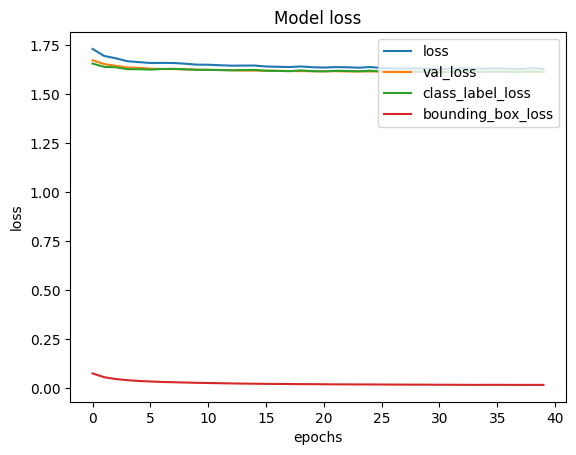

In [ ]:
# resnet finetune
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['class_label_loss'])
plt.plot(h.history['bounding_box_loss'])

plt.title("Model loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss', 'val_loss', 'class_label_loss', 'bounding_box_loss'], loc='upper right')
plt.show()


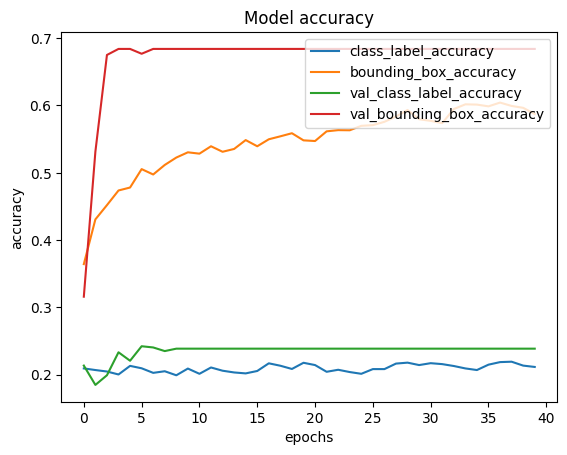

In [ ]:
plt.plot(h.history['class_label_accuracy'])
plt.plot(h.history['bounding_box_accuracy'])
plt.plot(h.history['val_class_label_accuracy'])
plt.plot(h.history['val_bounding_box_accuracy'])

plt.title("Model accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['class_label_accuracy', 'bounding_box_accuracy', 'val_class_label_accuracy', 'val_bounding_box_accuracy'], loc='upper right')
plt.show()

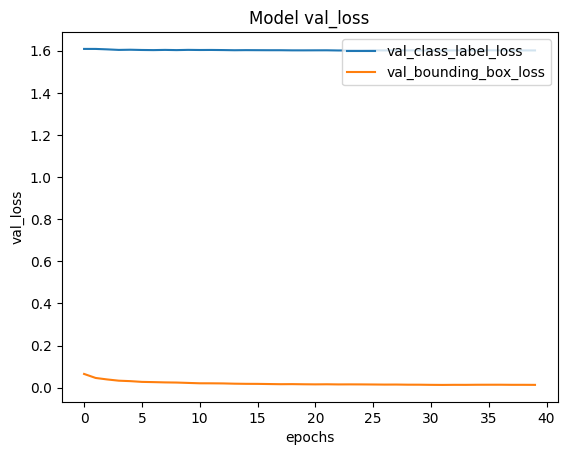

In [ ]:
plt.plot(h.history['val_class_label_loss'])
plt.plot(h.history['val_bounding_box_loss'])


plt.title("Model val_loss")
plt.xlabel("epochs")
plt.ylabel("val_loss")
plt.legend(['val_class_label_loss', 'val_bounding_box_loss'], loc='upper right')
plt.show()

# **Resnet50 Feature Extractor nobox**

In [ ]:
from keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

def ResNet50_Transfer_nobox():
    inputs = keras.Input(shape=(128, 128, 3))

    data_augmentation = keras.Sequential([
        layers.Resizing(256, 256),
        layers.GaussianNoise(0.2),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ])(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_tensor=data_augmentation)

    num_layers_finetune = 4
    num_layers = len(base_model.layers)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output

    x = Conv2D(filters=64, kernel_size=1, padding='valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=1, padding='valid')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)

    label = layers.Dense(5, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=label)
    return model

# Test
model = ResNet50_Transfer_nobox()
print(model.summary())
# plot_model(model, to_file="mlp.png", show_shapes=True)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 256, 256, 3)          0         ['input_10[0][0]']            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['sequential_9[0][0]']        
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                            

In [ ]:
sgd = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=sgd, metrics=['accuracy'], loss="categorical_crossentropy")

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/resnet50_transfer_nobox.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_accuracy')
callbacks = [checkpointer]
h = model.fit(train_ds, epochs=80, batch_size=16, verbose=1, shuffle=True,
            validation_data=val_ds,
            callbacks=callbacks
          )
model.save("/content/drive/MyDrive/resnet50_transfer_nobox.h5")

Epoch 1/80
54/54 [==============================] - ETA: 0s - loss: 0.8936 - accuracy: 0.5224
Epoch 1: val_accuracy improved from -inf to 0.48168, saving model to /content/drive/MyDrive/resnet50_transfer_nobox.h5
54/54 [==============================] - 24s 351ms/step - loss: 0.8936 - accuracy: 0.5224 - val_loss: 0.8973 - val_accuracy: 0.4817
Epoch 2/80
54/54 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.5771
Epoch 2: val_accuracy improved from 0.48168 to 0.51832, saving model to /content/drive/MyDrive/resnet50_transfer_nobox.h5
54/54 [==============================] - 11s 177ms/step - loss: 0.7335 - accuracy: 0.5771 - val_loss: 0.8220 - val_accuracy: 0.5183
Epoch 3/80
54/54 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.6213
Epoch 3: val_accuracy did not improve from 0.51832
54/54 [==============================] - 10s 166ms/step - loss: 0.7050 - accuracy: 0.6213 - val_loss: 0.7777 - val_accuracy: 0.5183
Epoch 4/80
54/54 [============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


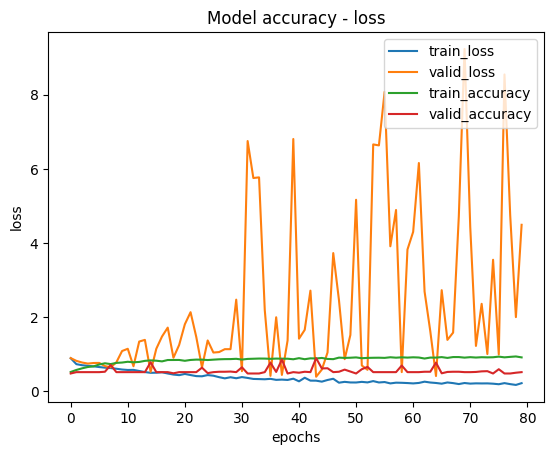

In [ ]:
# resnet finetune
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title("Model accuracy - loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy'], loc='upper right')
plt.show()


confusion matrix

13/13 [==============================] - 3s 112ms/step


<Figure size 1000x800 with 0 Axes>

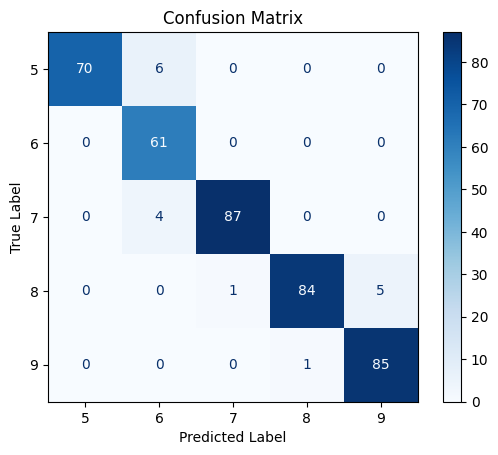

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán nhãn của dữ liệu kiểm tra
y_pred = np.argmax(model.predict(X_test), axis=1)

# Lấy nhãn thực tế của dữ liệu kiểm tra
true_labels = np.argmax(y_test, axis=1)  # y_test là nhãn one-hot

# Tạo confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Hiển thị confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
file_model = '/content/drive/MyDrive/HandDetection/resnet50_transfer_noaug.h5'

loaded_model = load_model(file_model)


In [ ]:
bla = loaded_model.evaluate(test_generator)

13/13 [==============================] - 109s 8s/step - loss: 0.1135 - accuracy: 0.9480


Shape test (1, 256, 256, 3)
1/1 [==============================] - 0s 301ms/step
[[2.9031000e-05 1.2125266e-13 4.1528114e-09 1.8459283e-03 9.9812502e-01]]
itemindex:(array([0]), array([4]))
probability: 99.81250166893005%
Predicted class :  9


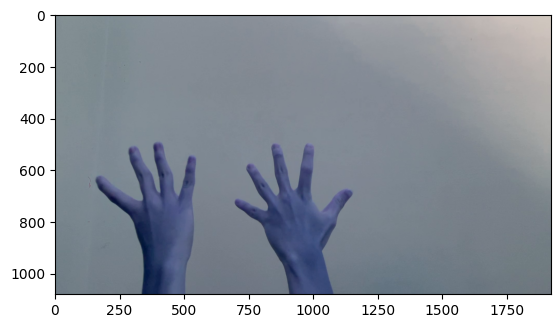

In [ ]:
def test_predict(test_img):
    labels = ["5", "6", "7", "8", "9"]
    img = cv2.imread(test_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (256, 256))
    img_arr = np.asarray(img_resize)
    img_arr = np.expand_dims(img_arr, axis=0) #Thêm chiều None (batch_size) vào [(None, 160, 160, 3)] để phù hợp vs model

    print('Shape test', img_arr.shape)
    pred = loaded_model.predict(img_arr)
    print(pred)
    itemindex = np.where(pred == np.max(pred))
    print('itemindex:{}'.format(itemindex))
    prediction = itemindex[1][0]
    print("probability: " + str(np.max(pred) * 100) + "%\nPredicted class : ", labels[prediction])

    img = cv2.imread(test_img)
    plt.imshow(img)


test_predict('/content/drive/MyDrive/img1266.png')


In [ ]:
loaded_model.evaluate(X_test, y_test, verbose=1)

13/13 [==============================] - 95s 7s/step - loss: 0.1016 - accuracy: 0.9752


[0.10157506167888641, 0.9752475023269653]

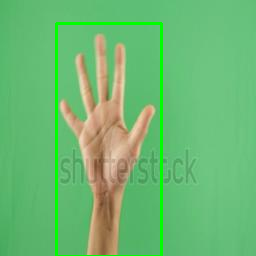

In [ ]:
# prompt: đọc ảnh và vẽ bounding box lên ảnh

import cv2
import numpy as np
from google.colab.patches import cv2_imshow
def draw_bounding_box(image, bounding_box, color=(0, 255, 0), thickness=2):
  """
  Draws a bounding box on the given image.

  Args:
    image: The image on which to draw the bounding box.
    bounding_box: A tuple containing the top-left corner coordinates and the bottom-right corner coordinates of the bounding box.
    color: The color of the bounding box.
    thickness: The thickness of the bounding box lines.

  Returns:
    The image with the bounding box drawn on it.
  """

  # Get the top-left and bottom-right corner coordinates of the bounding box.
  top_left, bottom_right = bounding_box

  # Draw the bounding box lines.
  cv2.rectangle(image, top_left, bottom_right, color, thickness)

  # Return the image with the bounding box drawn on it.
  return image

# Load the image.
image = cv2.imread('/content/drive/MyDrive/handData/img0001_png.rf.9b0ef6f49eb1ccd45a99d2e6515ba934.jpg')

# Create a bounding box.
bounding_box = ((56, 23), (161, 256))

# Draw the bounding box on the image.
image_with_bounding_box = draw_bounding_box(image, bounding_box)

# Show the image with the bounding box.
cv2_imshow(image_with_bounding_box)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50 model without including top layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
])

# Add new top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=data_augmentation,
    rescale=1./255)  # You may need to adjust this rescaling factor

validation_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation data

# Define data flow from directory (adjust batch size as needed)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


# **Resnet50 finetuning FPN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

def feature_pyramid_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    data_augmentation = keras.Sequential([
                                          # layers.Resizing(256, 256),
                                          # layers.Rescaling(1.0 / 255),
                                          layers.GaussianNoise(0.2),
                                          layers.RandomFlip("horizontal"),
                                          layers.RandomRotation(0.1),
                                          layers.RandomZoom(0.2),
                                          ])(inputs)

    # Base model
    base_model = ResNet50(include_top=False,
                          input_tensor=data_augmentation,
                          weights='imagenet',
                          # input_shape=(64,64,3)
                          )
    # base_model.trainable = True


    # Feature Pyramid Network (FPN)
    C3, C4, C5 = [base_model.get_layer(layer_name).output for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]

    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same', activation='relu')(C5)
    P4 = layers.Add()([layers.UpSampling2D(size=(2, 2))(P5), layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C4)])
    P3 = layers.Add()([layers.UpSampling2D(size=(2, 2))(P4), layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C3)])

    feature_pyramid = Model(inputs=inputs, outputs=[P3, P4, P5])
    print(feature_pyramid.summary())
    return feature_pyramid

def retina_net(num_classes, input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Feature Pyramid Network (FPN)
    feature_pyramid = feature_pyramid_network(input_shape)
    P3, P4, P5 = feature_pyramid(inputs)

    # Classification subnet
    cls_subnet = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(P3)
    # cls_subnet = layers.MaxPooling2D(3, strides=2)(cls_subnet)


    # cls_subnet = layers.MaxPooling2D(3, strides=2)(cls_subnet)
    # cls_subnet = layers.BatchNormalization(axis = 3)(cls_subnet)
    # cls_subnet = layers.Activation('relu')(cls_subnet)

    cls_subnet = layers.GlobalAveragePooling2D()(cls_subnet)
    # cls_subnet = layers.Dropout(0.3)(cls_subnet)
    # cls_subnet = layers.Dense(512, activation='softmax')(cls_subnet)
    cls_subnet = layers.Dense(256, activation='relu')(cls_subnet)
    cls_subnet = layers.Dropout(0.5)(cls_subnet)
    # cls_subnet = layers.Dense(512, activation='relu')(cls_subnet)
    # cls_subnet = layers.Dropout(0.5)(cls_subnet)
    cls_subnet = layers.Dense(num_classes, activation='softmax', name='cls_subnet')(cls_subnet)


    # Bounding Box regression subnet
    box_subnet = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(P3)
    # box_subnet = layers.BatchNormalization(axis=3)(box_subnet)
    # box_subnet = layers.Activation('relu')(box_subnet)

    # box_subnet = layers.MaxPooling2D(3, strides=2)(box_subnet)

    # box_subnet = layers.BatchNormalization(axis=3)(box_subnet)
    # box_subnet = layers.Activation('relu')(box_subnet)

    box_subnet = layers.GlobalAveragePooling2D()(box_subnet)
    # box_subnet = layers.Dropout(0.3)(box_subnet)
    # box_subnet = layers.Dense(512, activation='softmax')(box_subnet)
    box_subnet = layers.Dense(256, activation='relu')(box_subnet)
    box_subnet = layers.Dropout(0.5)(box_subnet)
    # box_subnet = layers.Dense(512, activation='relu')(box_subnet)
    # box_subnet = layers.Dropout(0.5)(box_subnet)
    box_subnet = layers.Dense(4, activation='sigmoid', name='box_subnet')(box_subnet)

    model = Model(inputs=inputs, outputs=[cls_subnet, box_subnet])
    losses = {
        "cls_subnet": "categorical_crossentropy",
        "box_subnet": "mean_squared_error",
    }
    loss_weights = {
        "cls_subnet": 1.0,
        "box_subnet": 1.0
    }

    # Compile the model
    optimizer = SGD(learning_rate=0.01, momentum=0.09)
    # optimizer = Adam(learning_rate=0.001)

    model.compile(loss=losses, optimizer=optimizer, metrics={"cls_subnet": "accuracy",
                                                             "box_subnet": "accuracy"},
                  loss_weights=loss_weights)
    return model

num_classes = 5
model = retina_net(num_classes)
model.summary()




94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                             

In [ ]:
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/resnet50_finetuning_fpn2.h5', verbose=1, save_best_only=True, save_weights_only=True, monitor='val_box_subnet_accuracy')
callbacks = [checkpointer]

h = model.fit(x = images_train, y = [labels_train, bboxes_train], epochs=40, batch_size=16, verbose=1,
            validation_data=(images_valid, [labels_valid, bboxes_valid]),
            callbacks=callbacks,
              shuffle=True
          )
# h = model.fit(images_train_ds, epochs=40, batch_size=16, verbose=1,
#             validation_data=images_valid_ds,
#             callbacks=callbacks,
#               shuffle=True
#           )
model.save("/content/drive/MyDrive/resnet50_finetuning_fpn2.h5")

Epoch 1/40
314/314 [==============================] - ETA: 0s - loss: 1.6490 - cls_subnet_loss: 1.6243 - box_subnet_loss: 0.0248 - cls_subnet_accuracy: 0.2072 - box_subnet_accuracy: 0.5786
Epoch 1: val_box_subnet_accuracy improved from -inf to 0.31598, saving model to /content/drive/MyDrive/resnet50_finetuning_fpn2.h5
314/314 [==============================] - 67s 128ms/step - loss: 1.6490 - cls_subnet_loss: 1.6243 - box_subnet_loss: 0.0248 - cls_subnet_accuracy: 0.2072 - box_subnet_accuracy: 0.5786 - val_loss: 1.8407 - val_cls_subnet_loss: 1.6544 - val_box_subnet_loss: 0.1863 - val_cls_subnet_accuracy: 0.1759 - val_box_subnet_accuracy: 0.3160
Epoch 2/40
313/314 [============================>.] - ETA: 0s - loss: 1.6256 - cls_subnet_loss: 1.6084 - box_subnet_loss: 0.0172 - cls_subnet_accuracy: 0.2181 - box_subnet_accuracy: 0.5988
Epoch 2: val_box_subnet_accuracy did not improve from 0.31598
314/314 [==============================] - 27s 85ms/step - loss: 1.6256 - cls_subnet_loss: 1.6084

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


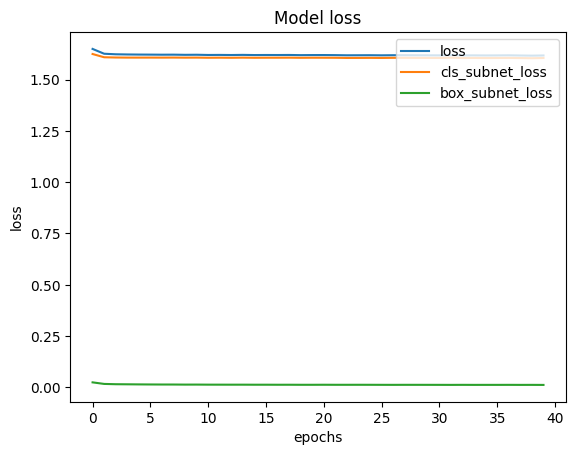

In [ ]:
# resnet finetune
plt.figure()
plt.plot(h.history['loss'])
plt.plot(h.history['cls_subnet_loss'])
plt.plot(h.history['box_subnet_loss'])
plt.title("Model loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['loss', 'cls_subnet_loss', 'box_subnet_loss', 'val_loss'], loc='upper right')
plt.show()


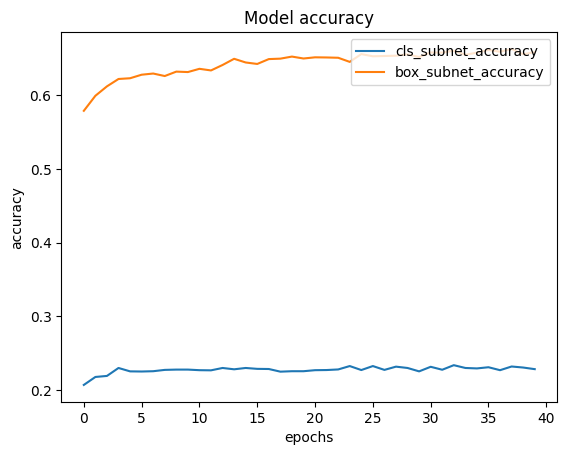

In [ ]:
# resnet finetune
plt.figure()
plt.plot(h.history['cls_subnet_accuracy'])
plt.plot(h.history['box_subnet_accuracy'])
plt.title("Model accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['cls_subnet_accuracy', 'box_subnet_accuracy'], loc='upper right')
plt.show()


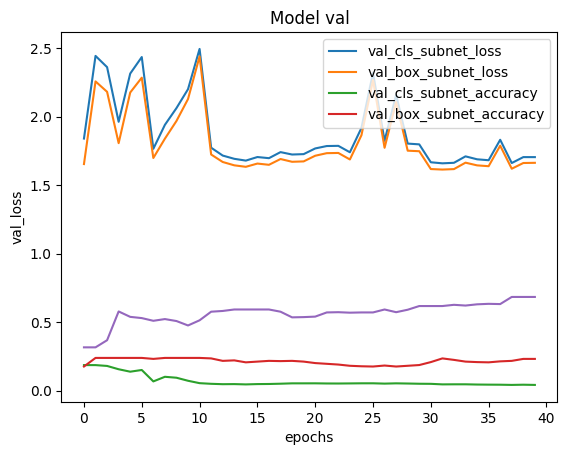

In [ ]:
# resnet finetune
plt.figure()
plt.plot(h.history['val_loss'])
plt.plot(h.history['val_cls_subnet_loss'])
plt.plot(h.history['val_box_subnet_loss'])
plt.plot(h.history['val_cls_subnet_accuracy'])
plt.plot(h.history['val_box_subnet_accuracy'])
plt.title("Model val")
plt.xlabel("epochs")
plt.ylabel("val_loss")

plt.legend(['val_cls_subnet_loss', 'val_box_subnet_loss', 'val_cls_subnet_accuracy', 'val_box_subnet_accuracy'], loc='upper right')
plt.show()


In [ ]:
file_model = '/content/drive/MyDrive/model/resnet50_transfer_box.h5'

loaded_model = load_model(file_model)


1/1 [==============================] - 0s 133ms/step
pred [[0.18237439 0.17804936 0.24048854 0.20650509 0.1925826 ]]
bbox [[0.2641137  0.27983108 0.7354906  0.76144624]]
itemindex: 2
probability: 24.048854410648346%
Predicted class :  7
x_min 0.2641137
336


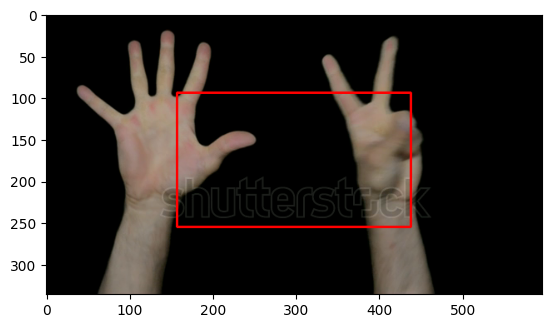

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_predict(test_img):
    labels = ["5", "6", "7", "8", "9"]
    img = cv2.imread(test_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (128, 128))
    img_arr = np.asarray(img_resize)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    pred, bbox = loaded_model.predict(img_arr)
    print('pred', pred)
    print('bbox', bbox)
    itemindex = np.argmax(pred)
    print('itemindex:', itemindex)
    prediction = itemindex
    print("probability: " + str(np.max(pred) * 100) + "%\nPredicted class : ", labels[prediction])

    # Vẽ bounding box
    x_min, y_min, x_max, y_max = bbox[0]
    print('x_min', x_min)
    h, w, _ = img_rgb.shape
    print(h)
    x1, y1 = int(x_min * w), int(y_min * h)
    x2, y2 = int(x_max * w), int(y_max * h)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(img_rgb)
    plt.show()

test_predict('/content/drive/MyDrive/test_data/hand7/img0306.png')


In [ ]:
file_model = '/content/drive/MyDrive/model/resnet50_finetuning_fpn2.h5'

loaded_model = load_model(file_model)


1/1 [==============================] - 3s 3s/step
pred [[0.17071402 0.16414958 0.34969163 0.1847142  0.13073052]]
bbox [[0.00179587 0.2716525  0.9892375  0.99962276]]
itemindex: 2
probability: 34.969162940979004%
Predicted class :  7
x_min 0.001795873
336


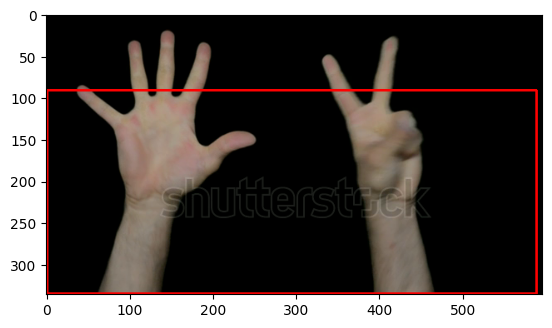

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_predict(test_img):
    labels = ["5", "6", "7", "8", "9"]
    img = cv2.imread(test_img)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (128, 128))
    img_arr = np.asarray(img_resize)/255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    pred, bbox = loaded_model.predict(img_arr)
    print('pred', pred)
    print('bbox', bbox)
    itemindex = np.argmax(pred)
    print('itemindex:', itemindex)
    prediction = itemindex
    print("probability: " + str(np.max(pred) * 100) + "%\nPredicted class : ", labels[prediction])

    # Vẽ bounding box
    x_min, y_min, x_max, y_max = bbox[0]
    print('x_min', x_min)
    h, w, _ = img_rgb.shape
    print(h)
    x1, y1 = int(x_min * w), int(y_min * h)
    x2, y2 = int(x_max * w), int(y_max * h)
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(img_rgb)
    plt.show()

test_predict('/content/drive/MyDrive/test_data/hand7/img0306.png')
